In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

# Handling data temporality with neural networks"

As seen in class, the basic form of a neural network is the feed forward neural network

A feed forward neural network with $L$ layers, where each layer $l$ has $n_l$ neurons can be described as below:

for a layer $l$ we have $n_l$ neurons :

$
\mathbf{h}^{(l)} = f^{(l)}\left(\mathbf{W}^{(l)} \mathbf{h}^{(l-1)} + \mathbf{b}^{(l)}\right),
$

where :

- $ \mathbf{h}^{(l-1)} \in \mathbb{R}^{n_{l-1}} $ is the activation vector of the previous layer ($\mathbf{h}^{(0)} = x$).
- $ \mathbf{W}^{(l)} \in \mathbb{R}^{n_l \times n_{l-1}} $ is the weight matrice.
- $ \mathbf{b}^{(l)} \in \mathbb{R}^{n_l} $ is the bias.
- $ f^{(l)} $ is an activation function.
- $ \mathbf{h}^{(l)} \in \mathbb{R}^{n_l} $ is the activation vector of the layer $ l $.

$
\hat{\mathbf{y}} = f^{(L)} \circ f^{(L-1)} \circ \dots \circ f^{(1)}(\mathbf{x}),
$


![notimportantname](../fig/neural_net_FF.png)


The basic feedforward architecture is not well-suited for time series because it lacks mechanisms to model temporal dependencies or capture sequential relationships between data points, which are essential for understanding patterns over time. To better capture the temporal dependencies and sequential patterns inherent in the data, more advanced architectures have been developed, specifically designed for processing temporal data


## Recurrent Neural Networks (RNNs)

Recurrent Neural Networks (RNNs) are a class of neural networks designed to process sequential data by capturing temporal dependencies. Unlike feedforward networks, RNNs have a feedback loop, allowing information to persist across time steps.


- **Temporal Dependencies:** RNNs model sequences by maintaining a hidden state $ \mathbf{h}_t $, which evolves over time based on the current input and the previous state:
  $
  \mathbf{h}_t = f(\mathbf{W}_h \mathbf{h}_{t-1} + \mathbf{W}_x \mathbf{x}_t + \mathbf{b}),
  $
  where:
  - $ \mathbf{x}_t $: Input at time $ t $,
  - $ \mathbf{h}_{t-1} $: Hidden state from the previous time step,
  - $ f $: Activation function.

- **Shared Parameters:** The same weights $ \mathbf{W}_h, \mathbf{W}_x $ are used at each time step, making RNNs efficient for sequential data. 

<img src="../fig/neural_net_RNN.png" alt="uselesstitle" width="600px">

Given a sequence of inputs $ x = \{x_1, x_2, \dots, x_T\} \in \mathbb{R}^{c \times T}$, the RNN model computes the outputs $ y = \{y_1, y_2, \dots, y_T\} $ as follows:

#### Initialization
- Initialize the hidden state:
  $
  h_0 = \mathbf{0} \quad \text{(a zero vector of size \texttt{hidden\_size})}
  $

#### Sequential Processing
For each timestep $ t = 1, 2, \dots, T $:
- Compute the new hidden state:
  $
  h_t = \sigma \left( W_{xh} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h \right)
  $
  Where:
  - $ x_t $ is the input at timestep $ t $,
  - $ W_{xh} $ maps the input to the hidden state (in $\mathbb{R}^{c \times h}$),
  - $ W_{hh} $ maps the previous hidden state to the current hidden state (in $\mathbb{R}^{h \times h}$),
  - $ b_h $ is the bias for the hidden state (in $\mathbb{R}^{h}$),
  - $ \sigma $ is the activation function.

- Compute the output:
  $
  y_t = W_{hy} \cdot h_t + b_y
  $
  Where:
  - $ W_{hy} $ maps the hidden state to the output,
  - $ b_y $ is the bias for the output.

- Store the output $ y_t $


In a first part, we will implement it with ```numpy``` to show how to calculate its gradient and to have a deep insight of the RNNs cells. When we will test the model, we will use ```torch``` to benefit from the autograd and the ```cuda``` implementation of the package.



In [42]:
class RNN:
    def __init__(self, input_size, hidden_size, output_size, activation=np.tanh):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation = activation

        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(output_size, hidden_size) * 0.01

        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def __call__(self, inputs):
        h = np.zeros((self.hidden_size, 1))
        outputs = []

        for x in inputs:
            x = x.reshape(-1, 1)
            h = self.activation(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            y = np.dot(self.Why, h) + self.by
            outputs.append(y)

        return np.array(outputs).squeeze()


input_size = 1
hidden_size = 5
output_size = 2

rnn = RNN(input_size, hidden_size, output_size)

inputs = np.array([1,1,1,1])
print(rnn(inputs).shape) # input_length x output_size 
rnn(inputs)[-1,:] # Return the last line only


(4, 2)


array([ 0.0002038 , -0.00026214])

A first advantage of this architecture is that it allows for varying the length of input data. Additionally, it can process long sequences with fewer parameters to train compared to traditional neural networks. Finally, the architecture is designed to ensure the model takes temporality into account (from left to right).

### Gradients for RNN

We use back propagation through time to compute the gradients of the RNN (thanks to this [site](https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-3/))

Since we are using the Mean Square Error as the loss function
$
l(y, \hat{y}) = \frac{1}{N} \sum_{t=1}^{T} (y_t - \hat{y}_t)^2
$

Where $ \hat{y}_t $ is the prediction of the RNN at step $ t $,

We have:


$
\frac{\partial l}{\partial y_t} = 2 \cdot (y_t - \hat{y}_t)
$

#### Gradient wrt $h_t$ 

$
\frac{\partial l}{\partial h_t} = \frac{\partial l}{\partial y_t} \cdot \frac{\partial y_t}{\partial h_t}
$

And:

$
\frac{\partial y_t}{\partial h_t} = W_{hy}
$

Using chain rule we have:

$
\frac{\partial l}{\partial h_t} = \frac{\partial l}{\partial y_t} \cdot W_{hy}
$

#### Gradient of tanh

Since the activation function is $ \tanh $, we have the following derivates :

$
\frac{\partial \tanh(h_t)}{\partial h_t} = 1 - \tanh^2(h_t)
$

Then we have :

$
\frac{\partial l}{\partial h_t} = \frac{\partial l}{\partial h_t} \cdot (1 - h_t^2)
$

#### Gradients wrt the weights at current states

We have :

$
\frac{\partial l}{\partial W_{xh}} = \frac{\partial l}{\partial h_t} \cdot x_t^T
$

The gradient of the loss function wrt $ W_{hh} $ is :

$
\frac{\partial l}{\partial W_{hh}} = \sum_{t} \frac{\partial l}{\partial h_t} \cdot h_{t-1}^T
$


The gradients for the output weights and bias are:

$
\frac{\partial l}{\partial W_{hy}} = \sum_{t=1}^T \frac{\partial l}{\partial y_t} \cdot h_t^T
$

$
\frac{\partial l}{\partial b_y} = \sum_{t=1}^T \frac{\partial l}{\partial y_t}
$

And finally, the gradients for the input-to-hidden,  hidden-to-hidden weights and for the hidden bias are:

$
\frac{\partial l}{\partial W_{xh}} = \sum_{t=1}^T \frac{\partial l}{\partial h_t} \cdot (1 - h_t^2) \cdot x_t^T
$

$
\frac{\partial l}{\partial W_{hh}} = \sum_{t=1}^T \frac{\partial l}{\partial h_t} \cdot (1 - h_t^2) \cdot h_{t-1}^T
$

$
\frac{\partial l}{\partial b_h} = \sum_{t=1}^T \frac{\partial l}{\partial h_t} \cdot (1 - h_t^2)
$

### Gradients for RNN

We use backpropagation through time (BPTT) to compute the gradients of the RNN (thanks to this [site](https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-3/)).

Since we are using the Mean Square Error (MSE) as the loss function:

$
l(y, \hat{y}) = \frac{1}{N} \sum_{t=1}^{T} (y_t - \hat{y}_t)^2
$

where $ \hat{y}_t $ is the prediction of the RNN at step $ t $,

We compute the gradient with respect to $ y_t $:

$
\frac{\partial l}{\partial y_t} = 2 \cdot (y_t - \hat{y}_t)
$

#### Gradients wrt $ h_t $

Using the chain rule:

$
\frac{\partial l}{\partial h_t} = \frac{\partial l}{\partial y_t} \cdot \frac{\partial y_t}{\partial h_t}
$

Since:

$
\frac{\partial y_t}{\partial h_t} = W_{hy}
$

We have:

$
\frac{\partial l}{\partial h_t} = \frac{\partial l}{\partial y_t} \cdot W_{hy}
$

#### Gradient of tanh

The activation function used is $ \tanh $, whose derivative is:

$
\frac{\partial \tanh(h_t)}{\partial h_t} = 1 - \tanh^2(h_t)
$

Substituting this into the equation:

$
\frac{\partial l}{\partial h_t} = \frac{\partial l}{\partial h_t} \cdot (1 - h_t^2)
$

#### Gradients wrt the weights

For the input-to-hidden weights $ W_{xh} $:

$
\frac{\partial l}{\partial W_{xh}} = \sum_{t=1}^T \frac{\partial l}{\partial h_t} \cdot (1 - h_t^2) \cdot x_t^T
$

For the hidden-to-hidden weights $ W_{hh} $:

$
\frac{\partial l}{\partial W_{hh}} = \sum_{t=1}^T \frac{\partial l}{\partial h_t} \cdot (1 - h_t^2) \cdot h_{t-1}^T
$

For the hidden bias $ b_h $:

$
\frac{\partial l}{\partial b_h} = \sum_{t=1}^T \frac{\partial l}{\partial h_t} \cdot (1 - h_t^2)
$

For the output weights $ W_{hy} $:

$
\frac{\partial l}{\partial W_{hy}} = \sum_{t=1}^T \frac{\partial l}{\partial y_t} \cdot h_t^T
$

For the output bias $ b_y $:

$
\frac{\partial l}{\partial b_y} = \sum_{t=1}^T \frac{\partial l}{\partial y_t}
$

---



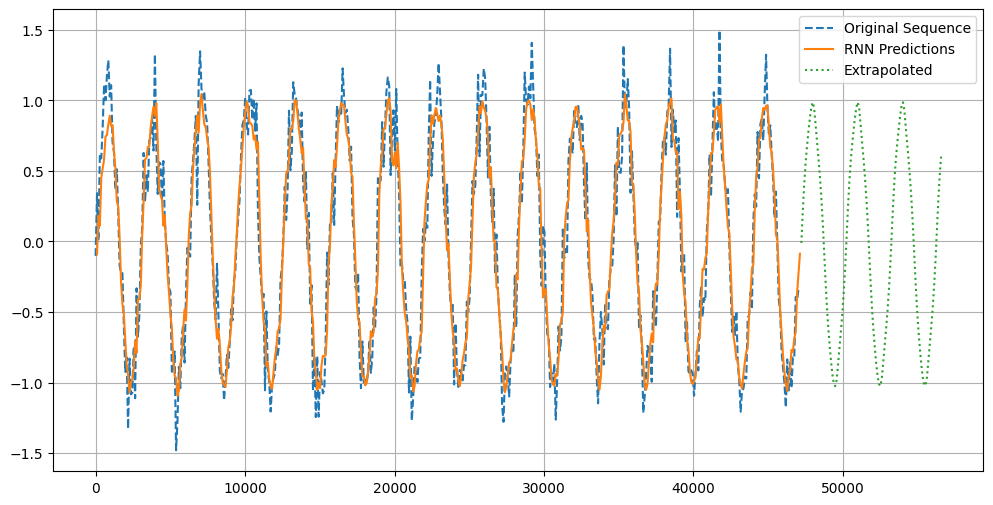

In [43]:
class RNN:
    def __init__(self, input_size, hidden_size, output_size, activation=np.tanh):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation = activation
        self.activation_derivative = lambda x: 1 - np.tanh(x)**2

        self.Wxh = np.random.randn(hidden_size, input_size) * 0.1
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.1
        self.Why = np.random.randn(output_size, hidden_size) * 0.1

        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def __call__(self, inputs):
        h = np.zeros((self.hidden_size, 1))
        outputs = []
        states = [h]

        for x in inputs:
            x = x.reshape(-1, 1)
            h = self.activation(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            y = np.dot(self.Why, h) + self.by
            outputs.append(y)
            states.append(h)

        return np.array(outputs).squeeze(), states

    def _backward(self, inputs, targets, states, outputs):
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dh_next = np.zeros((self.hidden_size, 1))
        gradient_norms = []

        for t in reversed(range(len(inputs))):
            x_t = inputs[t].reshape(-1, 1)
            y_t = outputs[t].reshape(-1, 1)
            h_t = states[t+1]
            h_prev = states[t]

            dy = y_t - targets[t].reshape(-1, 1)
            dWhy += np.dot(dy, h_t.T)
            dby += dy
            dh = np.dot(self.Why.T, dy) + dh_next
            dh_raw = dh * self.activation_derivative(h_t)
            dWxh += np.dot(dh_raw, x_t.T)
            dWhh += np.dot(dh_raw, h_prev.T)
            dbh += dh_raw
            dh_next = np.dot(self.Whh.T, dh_raw)
            gradient_norms.append(np.linalg.norm(dh_raw))

        return (dWxh, dWhh, dWhy, dbh, dby), gradient_norms[::-1]

    def update_weights(self, gradients, lr=0.01):
        dWxh, dWhh, dWhy, dbh, dby = gradients

        self.Wxh -= lr * dWxh
        self.Whh -= lr * dWhh
        self.Why -= lr * dWhy
        self.bh -= lr * dbh
        self.by -= lr * dby

    def train(self, inputs, targets, lr=0.01):
        outputs, states = self(inputs)
        gradients, _ = self._backward(inputs, targets, states, outputs)
        self.update_weights(gradients, lr)
        loss = np.mean((outputs - targets) ** 2)
        return loss


# We generate synthetic data

def generate_sine_wave(length, n_waves=30, amplitude=1, frequency=0.1, noise=0.2):
    x = np.linspace(0, n_waves * np.pi * frequency * length, length)
    y = amplitude * np.sin(x) + noise * np.random.randn(length)
    return x, y

sequence_length = 500
x, y = generate_sine_wave(sequence_length, frequency=1)

inputs = y[:-1].reshape(-1, 1)
targets = y[1:].reshape(-1, 1)

input_size = 1
hidden_size = 5
output_size = 1
rnn = RNN(input_size, hidden_size, output_size)

epochs = 2000
learning_rate = 0.01
losses = []


for epoch in range(epochs): # Actually it is not really an "epoch" but a batch

    idx = np.random.randint(0, len(y)-30)
    loss = rnn.train(inputs[idx:idx+30], targets[idx:idx+30], learning_rate)
    losses.append(loss)


predictions, _ = rnn(inputs)

extrapolated = []
input_seq = inputs[-1]
list_preds = []
prev = y.copy()

n_preds = 100

for _ in range(n_preds):
    preds = rnn(prev)[0][-1]
    prev = np.append(prev, preds)
    list_preds.append(preds)

plt.figure(figsize=(12, 6))
plt.plot(x[:-1], inputs, label="Original Sequence", linestyle="--")
plt.plot(x[1:], predictions, label="RNN Predictions")
plt.plot(x[-1:] + np.arange(1, n_preds + 1) * (x[1] - x[0]), np.concatenate([list_preds]), label="Extrapolated", linestyle="dotted")
plt.legend()
plt.grid(True)
plt.show()


### The Problem of Vanishing Gradients

When training RNNs with BPTT, gradients are propagated back in time through multiple time steps. This can result in two major problems:

1. **Vanishing Gradients**: 
   - The gradient components $ \frac{\partial l}{\partial h_t} $ contain terms like $ (1 - h_t^2) $ and repeated multiplication of weights $ W_{hh} $. If the spectral norm of $ W_{hh} $ is less than 1, the gradients shrink exponentially as they propagate backward through time. This leads to very small gradients for earlier time steps, making it difficult to update weights effectively for long-range dependencies.

2. **Exploding Gradients**:
   - If the spectral norm of $ W_{hh} $ is greater than 1, the gradients grow exponentially, causing instability during training. Gradient clipping is a common solution for this problem.

#### Why Vanishing Gradients Happen?

The core issue lies in the repeated application of the chain rule. For an RNN, the gradient at time \( t \) depends on all previous time steps. Mathematically:

$
\frac{\partial l}{\partial h_t} = \frac{\partial l}{\partial h_T} \cdot \prod_{k=t}^{T} \frac{\partial h_{k+1}}{\partial h_k}
$

The term $ \prod_{k=t}^{T} \frac{\partial h_{k+1}}{\partial h_k} $ represents the repeated multiplication of the Jacobian matrix $ W_{hh} $. If the eigenvalues of $ W_{hh} $ are less than 1, this product decays exponentially, leading to vanishing gradients.

#### Consequences

- Long-range dependencies cannot be learned effectively because gradients corresponding to earlier time steps become negligible.
- The model focuses on short-term patterns, limiting its ability to capture temporal dependencies in data.

## Long Short Term Memory (LSTM)

As we've seen, classic RNNs suffer from the problem of **vanishing gradients** when errors are backpropagated over long sequences. This limits their ability to learn long-term dependencies in the data.

To overcome this limitation, advanced architectures like **LSTMs (Long Short-Term Memory)** were introduced (Hochreiter & Al [2019](https://www.bioinf.jku.at/publications/older/2604.pdf)). These models incorporate specific mechanisms, such as gates, to better manage information across longer sequences and prevent the vanishing or exploding gradients problem.


![uselessname](../fig/neural_net_lstm.png)


An LSTM unit consists of the following components:

#### 1. **Cell State**
The **cell state** is the memory of the LSTM. It acts like a conveyor belt that runs through the entire chain of the LSTM. The cell state carries information across time steps, allowing the model to remember information for long periods.

#### 2. **Gates**
LSTMs use three main gates to control how information is added to, updated, or removed from the cell state.

- **Forget Gate**: This gate decides what proportion of the previous cell state should be carried forward. It outputs a value between 0 and 1 for each number in the cell state $ C_{t-1} $. A value of 0 means "completely forget", and 1 means "completely remember".
  - Formula:  
    $
    f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
    $
    Where $ f_t $ is the forget gate output, $ h_{t-1} $ is the previous hidden state, and $ x_t $ is the input at time step $ t $.

- **Input Gate**: This gate determines which values from the input $ x_t $ and the previous hidden state $ h_{t-1} $ should be added to the cell state. It is controlled by the **input gate** and an intermediate **candidate cell state**.
  - Formula:  
    $
    i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
    $
    Where $ i_t $ is the input gate output, and $ \tilde{C}_t $ is the candidate cell state.
  
- **Update the Cell State**: The cell state is updated by combining the previous cell state, the forget gate’s decision, and the input gate’s update.
  - Formula:  
    $
    C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
    $
    Where $ C_t $ is the updated cell state, $ C_{t-1} $ is the previous cell state, and $ \tilde{C}_t $ is the candidate cell state.

- **Output Gate**: This gate determines what the next hidden state $ h_t $ should be. The hidden state will be used for the prediction and also passed to the next time step. It is calculated based on the cell state and the output gate.
  - Formula:  
    $
    o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
    $
    Where $ o_t $ is the output gate.

- **Hidden State**: Finally, the hidden state $ h_t $ is computed using the updated cell state and the output gate:
  - Formula:  
    $
    h_t = o_t \cdot \tanh(C_t)
    $

---

/tmp/ipykernel_9736/2500571287.py:149: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  diff[0] = 2 * (pred[0] - label)


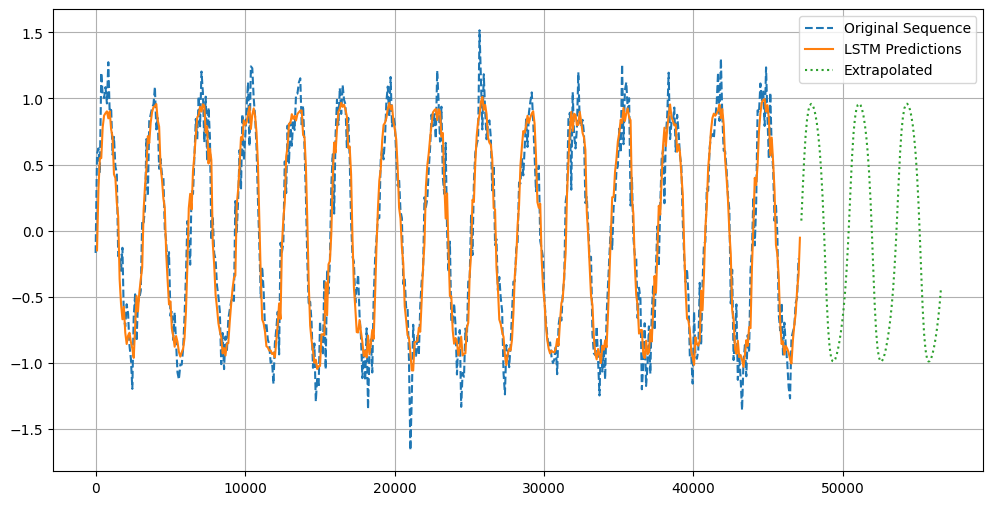

In [46]:
# We follow the basic LSTM unit
def sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def sigmoid_derivative(values): 
    return values * (1 - values)

# Unfortunatly, we don't have the time to implement an autograd so we need to create the functions
# Of the derivatives.

def tanh_derivative(values): 
    return 1. - values ** 2

def rand_arr(a, b, *args):
    """A simple function to initialise the weights
    """ 
    np.random.seed(0)
    return (np.random.rand(*args) * (b - a) + a) * 0.1

class LstmParam:
    def __init__(self, mem_cell_ct, x_dim):
        self.mem_cell_ct = mem_cell_ct
        self.x_dim = x_dim
        concat_len = x_dim + mem_cell_ct
        
        # Initialization
        self.wg = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        self.wi = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len) 
        self.wf = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        self.wo = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)

        self.bg = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bi = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bf = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bo = rand_arr(-0.1, 0.1, mem_cell_ct)

        self.wg_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wi_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wf_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wo_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.bg_diff = np.zeros(mem_cell_ct) 
        self.bi_diff = np.zeros(mem_cell_ct) 
        self.bf_diff = np.zeros(mem_cell_ct) 
        self.bo_diff = np.zeros(mem_cell_ct) 

    def apply_diff(self, lr=0.1):
        # classic gradient descent
        self.wg -= lr * self.wg_diff
        self.wi -= lr * self.wi_diff
        self.wf -= lr * self.wf_diff
        self.wo -= lr * self.wo_diff

        self.bg -= lr * self.bg_diff
        self.bi -= lr * self.bi_diff
        self.bf -= lr * self.bf_diff
        self.bo -= lr * self.bo_diff

        # We need to reset them, 
        self.wg_diff = np.zeros_like(self.wg)
        self.wi_diff = np.zeros_like(self.wi) 
        self.wf_diff = np.zeros_like(self.wf) 
        self.wo_diff = np.zeros_like(self.wo) 
        self.bg_diff = np.zeros_like(self.bg)
        self.bi_diff = np.zeros_like(self.bi) 
        self.bf_diff = np.zeros_like(self.bf) 
        self.bo_diff = np.zeros_like(self.bo)

class LstmState:
    def __init__(self, mem_cell_ct, x_dim):
        self.g = np.zeros(mem_cell_ct)
        self.i = np.zeros(mem_cell_ct)
        self.f = np.zeros(mem_cell_ct)
        self.o = np.zeros(mem_cell_ct)
        self.s = np.zeros(mem_cell_ct)
        self.h = np.zeros(mem_cell_ct)
        self.bottom_diff_h = np.zeros_like(self.h)
        self.bottom_diff_s = np.zeros_like(self.s)

class LstmNode:
    def __init__(self, lstm_param, lstm_state):
        self.state = lstm_state
        self.param = lstm_param
        self.xc = None

    def bottom_data_is(self, x, s_prev=None, h_prev=None):
        if s_prev is None: s_prev = np.zeros_like(self.state.s)
        if h_prev is None: h_prev = np.zeros_like(self.state.h)
        self.s_prev = s_prev
        self.h_prev = h_prev
        xc = np.hstack((x, h_prev))
        self.state.g = np.tanh(np.dot(self.param.wg, xc) + self.param.bg)
        self.state.i = sigmoid(np.dot(self.param.wi, xc) + self.param.bi)
        self.state.f = sigmoid(np.dot(self.param.wf, xc) + self.param.bf)
        self.state.o = sigmoid(np.dot(self.param.wo, xc) + self.param.bo)
        self.state.s = self.state.g * self.state.i + s_prev * self.state.f
        self.state.h = self.state.s * self.state.o
        self.xc = xc

    def top_diff_is(self, top_diff_h, top_diff_s):
        ds = self.state.o * top_diff_h + top_diff_s
        do = self.state.s * top_diff_h
        di = self.state.g * ds
        dg = self.state.i * ds
        df = self.s_prev * ds

        di_input = sigmoid_derivative(self.state.i) * di 
        df_input = sigmoid_derivative(self.state.f) * df 
        do_input = sigmoid_derivative(self.state.o) * do 
        dg_input = tanh_derivative(self.state.g) * dg

        self.param.wi_diff += np.outer(di_input, self.xc)
        self.param.wf_diff += np.outer(df_input, self.xc)
        self.param.wo_diff += np.outer(do_input, self.xc)
        self.param.wg_diff += np.outer(dg_input, self.xc)
        self.param.bi_diff += di_input
        self.param.bf_diff += df_input       
        self.param.bo_diff += do_input
        self.param.bg_diff += dg_input

        dxc = np.zeros_like(self.xc)
        dxc += np.dot(self.param.wi.T, di_input)
        dxc += np.dot(self.param.wf.T, df_input)
        dxc += np.dot(self.param.wo.T, do_input)
        dxc += np.dot(self.param.wg.T, dg_input)

        self.state.bottom_diff_s = ds * self.state.f
        self.state.bottom_diff_h = dxc[self.param.x_dim:]

class LossLayer:
    @classmethod
    def loss(cls, pred, label, fn):
        if fn == 'mae':
            return cls.loss_mae(pred, label)
        else:

            return cls.loss_rmse(pred, label)

    @classmethod
    def loss_mae(cls, pred, label):
        return np.abs(pred[0] - label)

    @classmethod
    def loss_rmse(cls, pred, label):
        return (pred[0] - label) ** 2

    @classmethod
    def bottom_diff(cls, pred, label):
        diff = np.zeros_like(pred)
        diff[0] = 2 * (pred[0] - label)
        return diff

class LstmNetwork:
    def __init__(self, lstm_param, loss):
        self.lstm_param = lstm_param
        self.lstm_node_list = []
        self.x_list = []
        self.loss = loss

    def y_list_is(self, y_list, loss_layer):
        idx = len(self.x_list) - 1
        loss = 0
        diff_h = loss_layer.bottom_diff(self.lstm_node_list[idx].state.h, y_list[idx])
        diff_s = np.zeros(self.lstm_param.mem_cell_ct)
        self.lstm_node_list[idx].top_diff_is(diff_h, diff_s)
        idx -= 1
        while idx >= 0:
            loss += loss_layer.loss(self.lstm_node_list[idx].state.h, y_list[idx], self.loss)
            diff_h = loss_layer.bottom_diff(self.lstm_node_list[idx].state.h, y_list[idx])
            diff_h += self.lstm_node_list[idx + 1].state.bottom_diff_h
            diff_s = self.lstm_node_list[idx + 1].state.bottom_diff_s
            self.lstm_node_list[idx].top_diff_is(diff_h, diff_s)
            idx -= 1
        return loss

    def x_list_clear(self):
        self.x_list = []

    def x_list_add(self, x):
        self.x_list.append(x)
        if len(self.x_list) > len(self.lstm_node_list):
            lstm_state = LstmState(self.lstm_param.mem_cell_ct, self.lstm_param.x_dim)
            self.lstm_node_list.append(LstmNode(self.lstm_param, lstm_state))

        idx = len(self.x_list) - 1
        if idx == 0:
            self.lstm_node_list[idx].bottom_data_is(x)
        else:
            s_prev = self.lstm_node_list[idx - 1].state.s
            h_prev = self.lstm_node_list[idx - 1].state.h
            self.lstm_node_list[idx].bottom_data_is(x, s_prev, h_prev)

    def train(self, inputs, targets, learning_rate=0.1):
        self.x_list_clear()
        for i in range(len(inputs)):
            self.x_list_add(inputs[i])

        loss_value = self.y_list_is(targets, LossLayer)
        self.lstm_param.apply_diff(lr=learning_rate)
        
        return loss_value

    def __call__(self, inputs):

        self.x_list_clear()
        for i in range(len(inputs)):
            self.x_list_add(inputs[i])

        return [elem.state.h[0] for elem in self.lstm_node_list]


input_size = 1
hidden_size = 5
output_size = 1

lstm_param = LstmParam(hidden_size, input_size)
lstm_net = LstmNetwork(lstm_param, 'rmse')

sequence_length = 500
x, y = generate_sine_wave(sequence_length, frequency=1)

inputs = y[:-1].reshape(-1, 1)
targets = y[1:].reshape(-1, 1)

epochs = 2000
learning_rate = 0.01
losses = []


for epoch in range(epochs): # Still not an epoch :(

    idx = np.random.randint(0, len(y)-30)
    loss = lstm_net.train(inputs[idx:idx+30], targets[idx:idx+30], learning_rate)
    losses.append(loss)


predictions = lstm_net(inputs)

extrapolated = []
input_seq = inputs[-1]
list_preds = []
prev = y.copy()

n_preds = 100

for _ in range(n_preds):
    preds = lstm_net(prev)[-1]
    prev = np.append(prev, preds)
    list_preds.append(preds)

plt.figure(figsize=(12, 6))
plt.plot(x[:-1], inputs, label="Original Sequence", linestyle="--")
plt.plot(x[1:], predictions, label="LSTM Predictions")
plt.plot(x[-1:] + np.arange(1, n_preds + 1) * (x[1] - x[0]), np.concatenate([list_preds]), label="Extrapolated", linestyle="dotted")
plt.legend()
plt.grid(True)
plt.show()
